In [1]:
import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.utils.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

Using diffeqsolve-based neural simulation (original)


In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC DNg100 core CPG only $|I_\text{stim}|$ sweep

In [3]:
simType = "DNg100_Stim_CoreCPG"
simPath = simType+"/hyak/run_id=29278022"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

nSims = overallParams.experiment.n_replicates
nActive = pd.DataFrame(index=np.arange(nSims))
nMnsActive = pd.DataFrame(index=np.arange(nSims))
simScore = pd.DataFrame(index=np.arange(nSims))
mnFreq = pd.DataFrame(index=np.arange(nSims))

subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
for subfolder in subfolders:
    print(f"Loading {subfolder}")
    Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
    dataset = 0
    Rs = Rs[dataset]
    params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
    stimI = params.experiment.stimI[0]
    for i in range(nSims):
        # active neurons
        R = Rs[i]
        
        nActive.loc[i,stimI] = sum(np.max(R,1)>0.01)
        activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        nMnsActive.loc[i,stimI] = np.sum(activeMnsMask)
        activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
        simScore.loc[i,stimI] = score
        mnFreq.loc[i,stimI] = freq

nActive = nActive.transpose().sort_index().transpose()
nMnsActive = nMnsActive.transpose().sort_index().transpose()
simScore = simScore.transpose().sort_index().transpose()
mnFreq = mnFreq.transpose().sort_index().transpose()

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

Loading experiment.seed=207,experiment.stimI=[300]
Loading experiment.seed=207,experiment.stimI=[340]
Loading experiment.seed=207,experiment.stimI=[180]
Loading experiment.seed=207,experiment.stimI=[260]
Loading experiment.seed=207,experiment.stimI=[220]


In [5]:
# figFolder = "../figures/"
# figFolder += "-".join(str.split(simPath,"/"))

# nMnsActive = pd.read_csv(figFolder+"/nMnsActive.csv",index_col=0)
# simScore = pd.read_csv(figFolder+"/scores.csv",index_col=0)
# mnFreq = pd.read_csv(figFolder+"/frequencies.csv",index_col=0)

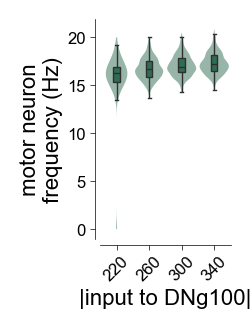

In [7]:
plt.figure(figsize=(0.84,1.426))
sns.violinplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin.svg",transparent=True)
plt.show()

In [9]:
mnFreq_plotShape = (mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency")
nMnsActive_plotShape = nMnsActive.iloc[:,1:].astype(float).melt(var_name="stimI",value_name="nMnsActive")

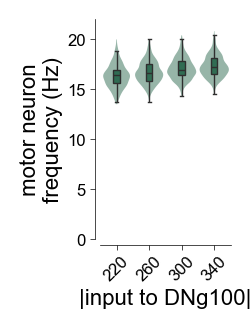

In [13]:
plt.figure(figsize=(0.84,1.426))
sns.violinplot(mnFreq_plotShape.loc[nMnsActive_plotShape["nMnsActive"]>0],x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot(mnFreq_plotShape.loc[nMnsActive_plotShape["nMnsActive"]>0],x="stimI",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)
plt.ylim([0,22])

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin_activeMnsOnly.svg",transparent=True)
plt.show()

In [14]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nActive.to_csv(figFolder+"/nActive.csv")
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")